In [9]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn import preprocessing
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from scipy.io import mmread
import os
import sys
from scipy.spatial.distance import cdist

import warnings

warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA

from gprofiler import GProfiler
from typing import List,Tuple

def query_genes(genes : List[str],
                organism : str,
                dbs : List[str],
                )-> pd.DataFrame:

    gp = GProfiler(return_dataframe = True)
    res = gp.profile(organism = organism,
                    query = genes,
                     )
    n_paths = res.shape[0]
    keep = np.array([x  for x in range(n_paths) if \
                     res['source'].values[x] in
                     dbs])
    res_sel = res.iloc[keep,:]
    res_sel = res_sel.loc[res_sel['significant'],:]

    return res_sel


In [10]:
adata = sc.read("./imputeData/Melanoma_results.h5ad")
adata

AnnData object with n_obs × n_vars = 293 × 13562
    obs: 'array_row', 'array_col', 'kmeans', 'Ground Truth'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'hvg', 'log1p'
    obsm: 'eval_pred', 'eval_recon', 'feat', 'spatial'

In [11]:
adata = adata[:, adata.var['highly_variable'] == True]
adata.layers["recon"] = adata.obsm["eval_recon"]
adata

AnnData object with n_obs × n_vars = 293 × 2000
    obs: 'array_row', 'array_col', 'kmeans', 'Ground Truth'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'hvg', 'log1p'
    obsm: 'eval_pred', 'eval_recon', 'feat', 'spatial'
    layers: 'recon'

In [12]:
from sklearn.metrics import adjusted_mutual_info_score, normalized_mutual_info_score, completeness_score, \
    fowlkes_mallows_score, homogeneity_score
from sklearn.metrics.cluster import v_measure_score, adjusted_rand_score


def measureClusteringTrueLabel(labels_true, labels_pred):
    ari = adjusted_rand_score(labels_true, labels_pred)
    ami = adjusted_mutual_info_score(labels_true, labels_pred)
    nmi = normalized_mutual_info_score(labels_true, labels_pred)
    cs = completeness_score(labels_true, labels_pred)
    fms = fowlkes_mallows_score(labels_true, labels_pred)
    vms = v_measure_score(labels_true, labels_pred)
    hs = homogeneity_score(labels_true, labels_pred)
    return ari, ami, nmi, cs, fms, vms, hs


sub_adata = adata[~pd.isnull(adata.obs['Ground Truth'])]
ari, ami, nmi, cs, fms, vms, hs = measureClusteringTrueLabel(sub_adata.obs['Ground Truth'], sub_adata.obs["kmeans"])
ari

0.5604739329589992

In [13]:
nmi

0.5007520312801822

In [14]:
adata.var_names

Index(['NELL1 ENSG00000165973', 'MFGE8 ENSG00000140545',
       'TSC22D3 ENSG00000157514', 'RASA4B ENSG00000170667',
       'SEC11C ENSG00000166562', 'IGFBP7 ENSG00000163453',
       'LGALS3 ENSG00000131981', 'VKORC1 ENSG00000167397',
       'IL24 ENSG00000162892', 'F2R ENSG00000181104',
       ...
       'MPV17L ENSG00000156968', 'FAM110D ENSG00000197245',
       'SRL ENSG00000185739', 'ARHGEF15 ENSG00000198844',
       'HOXA9 ENSG00000078399', 'SLC2A4 ENSG00000181856',
       'KIF26A ENSG00000066735', 'LCN6 ENSG00000267206',
       'CNR1 ENSG00000118432', 'WASIR2 ENSG00000231439'],
      dtype='object', name='gene', length=2000)

Text(0.5, 1.0, 'OUR (ARI:0.560)')

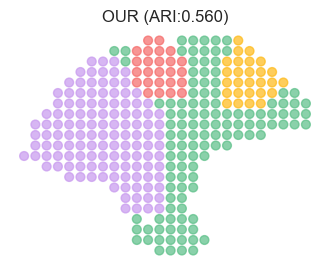

In [15]:
lv = '#59BE86'
hong = '#F56867'
huang = '#FEB915'
zi = '#C798EE'

# 指定颜色
colors = {
    1: huang,
    2: lv,
    3: zi,
    4: hong,
    -2147483647: '#7495D3'
}

x_coordinates = np.array(adata.obs['array_row'])
y_coordinates = np.array(adata.obs['array_col'])

values = np.array(adata.obs['kmeans'], dtype=int)
values = values + 1

fig, ax = plt.subplots(figsize=(4, 3))
scatter = ax.scatter(x_coordinates, y_coordinates, c=[colors[val] for val in values], alpha=0.7, s=40)

ax.axis('off')
# 添加标题
ax.set_title(f'OUR (ARI:{ari:0.3f})')
# plt.savefig('./our_domain.pdf')

(18.33644199371338, 32.45790767669678, 10.113161373138428, 20.832725238800048)

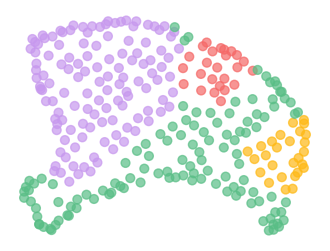

In [16]:
fig, ax = plt.subplots(figsize=(4, 3))
sc.pp.neighbors(adata, n_neighbors=12, n_pcs=30, use_rep="eval_pred")
sc.tl.umap(adata)
ax.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], c=[colors[val] for val in values], alpha=0.7, s=40)
ax.axis('off')
# plt.savefig('./our_umap.pdf')

In [17]:
adata.obs["re_kmeans"] =  adata.obs["kmeans"].values.astype(str)
adata

AnnData object with n_obs × n_vars = 293 × 2000
    obs: 'array_row', 'array_col', 'kmeans', 'Ground Truth', 're_kmeans'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'eval_pred', 'eval_recon', 'feat', 'spatial', 'X_umap'
    layers: 'recon'
    obsp: 'distances', 'connectivities'

         Falling back to preprocessing with `sc.pp.pca` and default params.


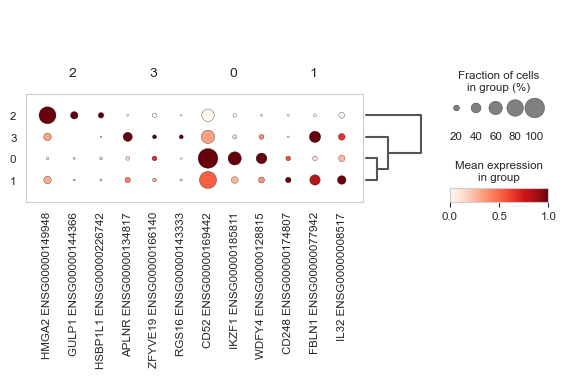

In [47]:
sc.tl.rank_genes_groups(adata, 're_kmeans', layer='recon')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, groupby='re_kmeans', min_logfoldchange=2, standard_scale='var')

categories: 0, 1, 2, etc.
var_group_labels: Domain 0, Domain 2, Domain 3


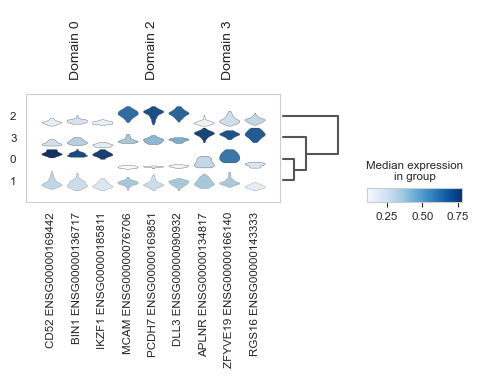

In [53]:
marker_genes_dict = {
    'Domain 0':['CD52 ENSG00000169442','BIN1 ENSG00000136717','IKZF1 ENSG00000185811'],
    'Domain 2':['MCAM ENSG00000076706','PCDH7 ENSG00000169851','DLL3 ENSG00000090932'],
    'Domain 3':['APLNR ENSG00000134817','ZFYVE19 ENSG00000166140','RGS16 ENSG00000143333'],
}
sc.pl.stacked_violin(adata, marker_genes_dict, groupby='re_kmeans', dendrogram=True, swap_axes=False,standard_scale='var',layer='recon', save='stacked_violin.pdf')

In [18]:
sc.tl.rank_genes_groups(adata, 're_kmeans', groups=['0'], reference='2', key_added = "0vs2_Raw")
sc.tl.rank_genes_groups(adata, 're_kmeans', groups=['0'], reference='2', key_added = "0vs2_Impute", layer='recon')

In [19]:
log2fc_min = 2
g_0vs2_Raw_f = list(sc.get.rank_genes_groups_df(adata, group='0', key='0vs2_Raw', pval_cutoff=0.05, log2fc_min=log2fc_min)['names'])
g_0vs2_Impute_f = list(sc.get.rank_genes_groups_df(adata, group='0', key='0vs2_Impute', pval_cutoff=0.05, log2fc_min=log2fc_min)['names'])
g_0vs2_Raw = [item.split()[0] for item in g_0vs2_Raw_f]
g_0vs2_Impute = [item.split()[0] for item in g_0vs2_Impute_f]
len(g_0vs2_Raw), len(g_0vs2_Impute)

(169, 250)

In [20]:
res_Raw = query_genes(genes=g_0vs2_Raw,organism="hsapiens",dbs = ["GO:BP"])
res_Impute = query_genes(genes=g_0vs2_Impute,organism="hsapiens",dbs = ["GO:BP"])
len(res_Raw), len(res_Impute)

(360, 214)

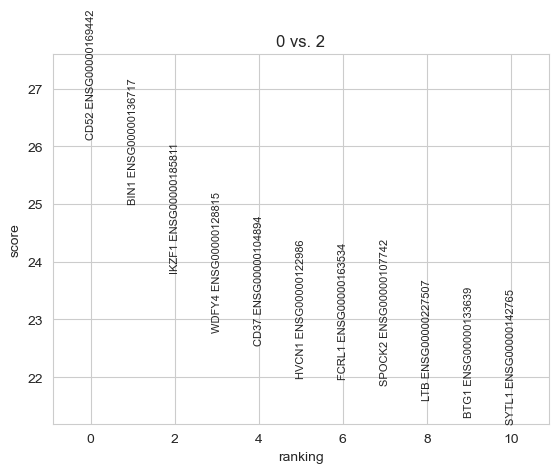

In [21]:
sc.pl.rank_genes_groups(adata, n_genes=11, groups='0', key='0vs2_Impute',save='0vs2_Impute_gene.pdf')

"A change in morphology and behavior of a lymphocyte resulting from exposure to a specific antigen, mitogen, cytokine, chemokine, cellular ligand, or soluble factor." [GOC:mgi_curators, ISBN:07817...

In [22]:
res_Impute

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0046649,lymphocyte activation,2.388921e-27,True,"""A change in morphology and behavior of a lymp...",783,215,55,21031,0.255814,0.070243,query_1,[GO:0045321]
1,GO:BP,GO:0001775,cell activation,4.068736e-27,True,"""A multicellular organismal process by which e...",1092,215,63,21031,0.293023,0.057692,query_1,"[GO:0009987, GO:0032501]"
2,GO:BP,GO:0045321,leukocyte activation,7.016103e-27,True,"""A change in morphology and behavior of a leuk...",946,215,59,21031,0.274419,0.062368,query_1,"[GO:0001775, GO:0002376]"
3,GO:BP,GO:0002376,immune system process,5.851698e-23,True,"""Any process involved in the development or fu...",2776,215,91,21031,0.423256,0.032781,query_1,[GO:0008150]
5,GO:BP,GO:0006955,immune response,3.295584e-17,True,"""Any immune system process that functions in t...",1988,215,69,21031,0.320930,0.034708,query_1,"[GO:0002376, GO:0050896]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,GO:BP,GO:0001932,regulation of protein phosphorylation,4.479504e-02,True,"""Any process that modulates the frequency, rat...",910,215,24,21031,0.111628,0.026374,query_1,"[GO:0006468, GO:0031399, GO:0042325]"
383,GO:BP,GO:0002443,leukocyte mediated immunity,4.630092e-02,True,"""Any process involved in the carrying out of a...",460,215,16,21031,0.074419,0.034783,query_1,[GO:0002252]
384,GO:BP,GO:0038093,Fc receptor signaling pathway,4.701971e-02,True,"""The series of molecular signals initiated by ...",56,215,6,21031,0.027907,0.107143,query_1,[GO:0002768]
386,GO:BP,GO:0033631,cell-cell adhesion mediated by integrin,4.744206e-02,True,"""The attachment of one cell to another cell vi...",17,215,4,21031,0.018605,0.235294,query_1,"[GO:0033627, GO:0098609]"


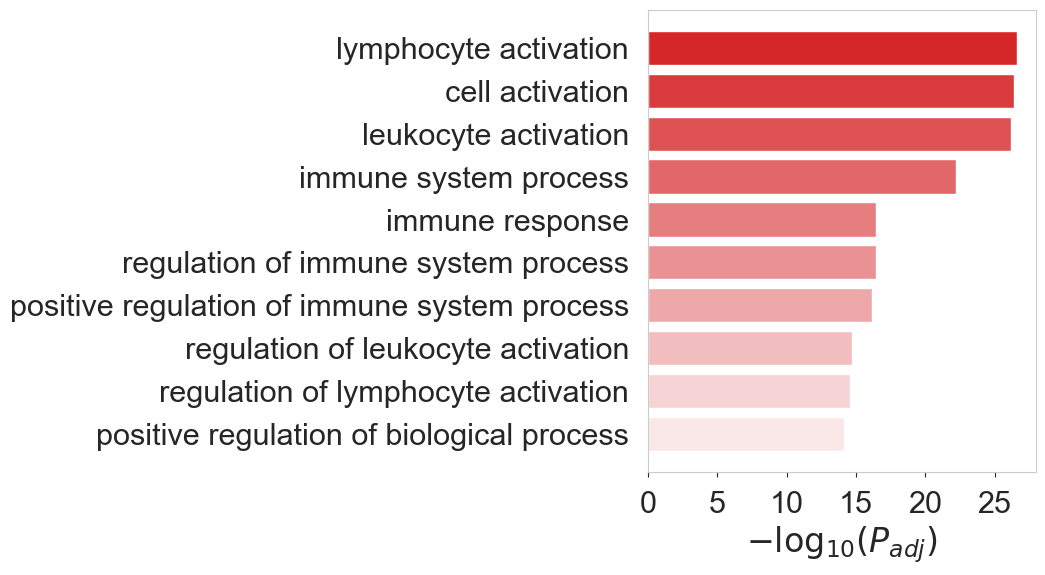

In [38]:
res_Impute.index = range(len(res_Impute))
go_colors = ["#FFEBEDFF", "#FFCCD2FF", "#EE9999FF", "#E57272FF", "#EE5250FF",
             "#F34335FF", "#E53934FF", "#D22E2EFF", "#C52727FF", "#B71B1BFF"][::-1]

import matplotlib.colors

alphas = np.linspace(0.1, 1, 10)
rgba_colors = np.zeros((10, 4))
# for red the first column needs to be one
rgba_colors[:, :3] = matplotlib.colors.hex2color("tab:red")
# the fourth column needs to be your alphas
rgba_colors[:, 3] = alphas
go_colors = rgba_colors[::-1]

plt.figure(figsize=(5, 6))

for i in range(10):
    plt.barh(10 - i, -np.log10(res_Impute.loc[i]['p_value']), color=go_colors[i])

plt.xticks(fontsize=22)
plt.yticks(10 - np.arange(10), [go for go in res_Impute['name'][:10].values], fontsize=22)
ax = plt.gca()
ax.tick_params(axis='both', which='major', pad=10)
ax.xaxis.set_ticks_position('bottom')
ax.grid(False)
plt.xlabel("$-\log_{10}(P_{adj})$", fontsize=24)
plt.savefig('./go_bp_0vs2.pdf')

In [55]:
mg_0vs2 = g_0vs2_Impute_f[:20]
mg_0vs2

['CD52 ENSG00000169442',
 'BIN1 ENSG00000136717',
 'IKZF1 ENSG00000185811',
 'WDFY4 ENSG00000128815',
 'CD37 ENSG00000104894',
 'HVCN1 ENSG00000122986',
 'FCRL1 ENSG00000163534',
 'SPOCK2 ENSG00000107742',
 'LTB ENSG00000227507',
 'BTG1 ENSG00000133639',
 'SYTL1 ENSG00000142765',
 'PKIA ENSG00000171033',
 'BIRC3 ENSG00000023445',
 'IL24 ENSG00000162892',
 'AKNA ENSG00000106948',
 'LINC00926 ENSG00000247982',
 'MS4A1 ENSG00000156738',
 'LCP1 ENSG00000136167',
 'CD19 ENSG00000177455',
 'TNFAIP8 ENSG00000145779']

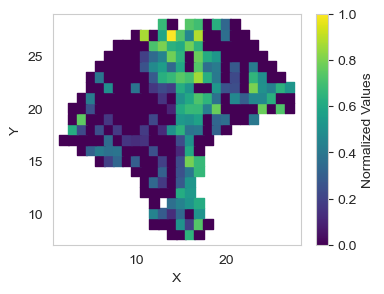

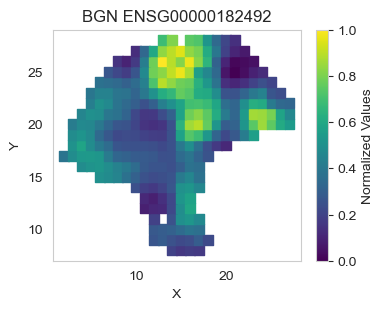

In [61]:
from matplotlib.colors import Normalize
plt.rcParams["figure.figsize"] = (3, 3)

denoise_adata = adata

for gene in mg_0vs2[:5]:
    idx = denoise_adata.var.index.tolist().index(gene)  #输出基因的idx
    values = denoise_adata.X.toarray()[:, idx]
    # 归一化数据
    normalized_values = (values - np.min(values)) / (np.max(values) - np.min(values))
    # 创建归一化对象
    norm = Normalize(vmin=0, vmax=1)
    # 创建图形和坐标轴
    fig, ax = plt.subplots(figsize=(4,3))
    # 绘制散点图，设置方块形状
    plot_sc = ax.scatter(x_coordinates, y_coordinates, c=normalized_values, cmap='viridis', norm=norm, marker='s', s=50)
    # 添加颜色条
    cbar = plt.colorbar(plot_sc, ax=ax)
    cbar.set_label('Normalized Values')
    # 设置坐标轴标签
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(False)
    plt.savefig('./figures/Gene_' + gene + '_Raw.pdf')
    values = denoise_adata.layers['recon'][:, idx]
    # 归一化数据
    normalized_values = (values - np.min(values)) / (np.max(values) - np.min(values))
    # 创建归一化对象
    norm = Normalize(vmin=0, vmax=1)
    # 创建图形和坐标轴
    fig, ax = plt.subplots(figsize=(4,3))
    # 绘制散点图，设置方块形状
    plt_Sc = ax.scatter(x_coordinates, y_coordinates, c=normalized_values, cmap='viridis', norm=norm, marker='s', s=50)
    # 添加颜色条
    cbar = plt.colorbar(plt_Sc, ax=ax)
    cbar.set_label('Normalized Values')
    # 设置坐标轴标签
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(gene)
    ax.grid(False)
    plt.savefig('./figures/Gene_' + gene + '_Impute.pdf')

In [26]:
sc.tl.rank_genes_groups(adata, 're_kmeans', groups=['2'], reference='0', key_added="2vs0_Raw")
sc.tl.rank_genes_groups(adata, 're_kmeans', groups=['2'], reference='0', key_added="2vs0_Impute", layer='recon')
g_2vs0_Raw_f = list(sc.get.rank_genes_groups_df(adata, group='2', key='2vs0_Raw', pval_cutoff=0.05, log2fc_min=log2fc_min)['names'])
g_2vs0_Impute_f = list(sc.get.rank_genes_groups_df(adata, group='2', key='2vs0_Impute', pval_cutoff=0.05, log2fc_min=log2fc_min)['names'])
g_2vs0_Raw = [item.split()[0] for item in g_2vs0_Raw_f]
g_2vs0_Impute = [item.split()[0] for item in g_2vs0_Impute_f]
print(len(g_2vs0_Raw),len(g_0vs2_Impute))

465 250


In [27]:
res_Raw_20 = query_genes(genes=g_2vs0_Raw, organism="hsapiens", dbs=["GO:BP"])
res_Impute_20 = query_genes(genes=g_2vs0_Impute, organism="hsapiens", dbs=["GO:BP"])
print(len(res_Raw_20),len(res_Impute_20))

150 125


In [28]:
res_Impute_20

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0032502,developmental process,5.514707e-16,True,"""A biological process whose specific outcome i...",6453,257,148,21031,0.575875,0.022935,query_1,[GO:0008150]
1,GO:BP,GO:0048856,anatomical structure development,2.022628e-14,True,"""The biological process whose specific outcome...",5899,257,137,21031,0.533074,0.023224,query_1,[GO:0032502]
2,GO:BP,GO:0007275,multicellular organism development,2.764365e-13,True,"""The biological process whose specific outcome...",4643,257,116,21031,0.451362,0.024984,query_1,"[GO:0032501, GO:0048856]"
3,GO:BP,GO:0048731,system development,1.185354e-11,True,"""The process whose specific outcome is the pro...",3973,257,102,21031,0.396887,0.025673,query_1,"[GO:0007275, GO:0048856]"
5,GO:BP,GO:0009653,anatomical structure morphogenesis,1.580733e-11,True,"""The process in which anatomical structures ar...",2684,257,80,21031,0.311284,0.029806,query_1,"[GO:0032502, GO:0048856]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,GO:BP,GO:0120035,regulation of plasma membrane bounded cell pro...,3.824597e-02,True,"""Any process that modulates the frequency, rat...",652,257,22,21031,0.085603,0.033742,query_1,"[GO:0031344, GO:0120036]"
171,GO:BP,GO:0043069,negative regulation of programmed cell death,4.007363e-02,True,"""Any process that stops, prevents, or reduces ...",907,257,27,21031,0.105058,0.029768,query_1,"[GO:0012501, GO:0043067, GO:0048523]"
172,GO:BP,GO:0001558,regulation of cell growth,4.178593e-02,True,"""Any process that modulates the frequency, rat...",424,257,17,21031,0.066148,0.040094,query_1,"[GO:0016049, GO:0040008, GO:0051128]"
173,GO:BP,GO:0042060,wound healing,4.305729e-02,True,"""The series of events that restore integrity t...",425,257,17,21031,0.066148,0.040000,query_1,[GO:0009611]


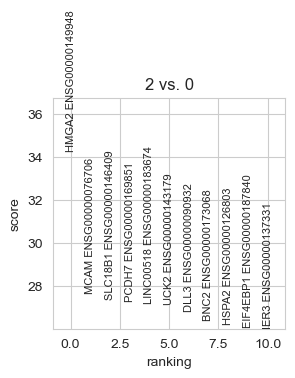

In [29]:
sc.pl.rank_genes_groups(adata, n_genes=11, groups='2', key='2vs0_Impute', save='2vs0_Impute_gene.pdf')

In [30]:
mg_2vs_0 = g_2vs0_Impute_f
mg_2vs_0[:10]

['MCAM ENSG00000076706',
 'SLC18B1 ENSG00000146409',
 'PCDH7 ENSG00000169851',
 'DLL3 ENSG00000090932',
 'HSPA2 ENSG00000126803',
 'IER3 ENSG00000137331',
 'CYFIP1 ENSG00000273749',
 'DUSP4 ENSG00000120875',
 'CCND1 ENSG00000110092',
 'HAPLN1 ENSG00000145681']

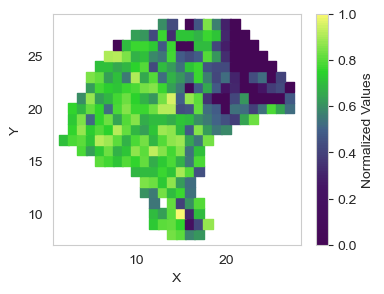

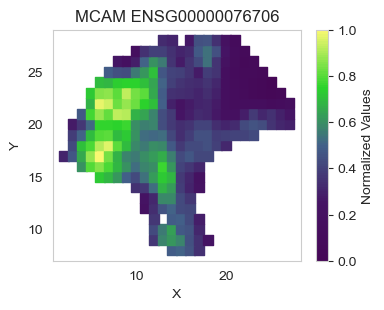

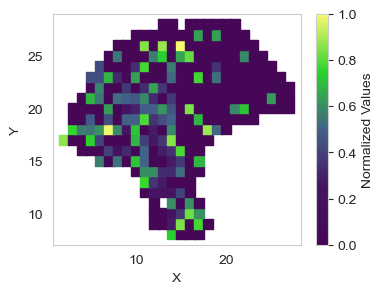

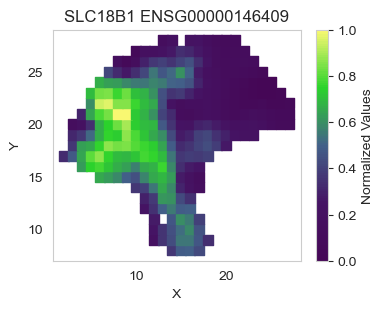

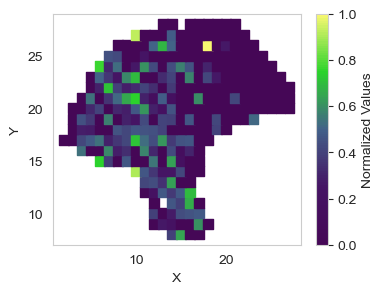

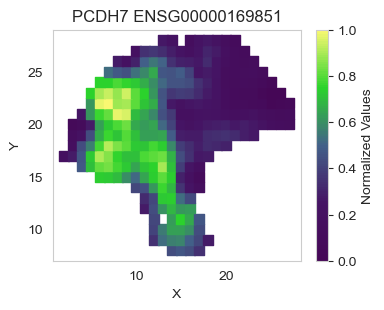

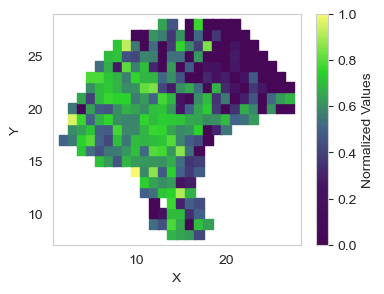

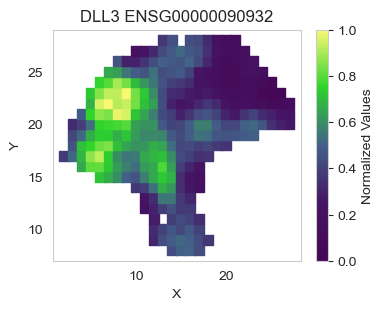

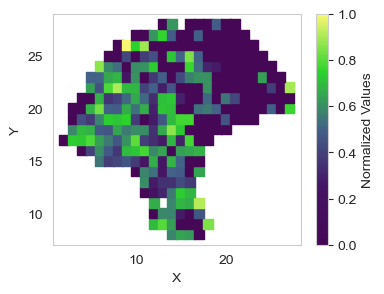

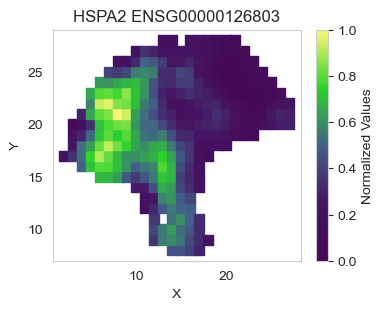

In [44]:
from matplotlib.colors import Normalize
plt.rcParams["figure.figsize"] = (3, 3)

denoise_adata = adata
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plot_color=['#450756','#451464','#426189', '#2BD32B','#F9F871']
newcmp = LinearSegmentedColormap.from_list('new',plot_color, N=100)
for gene in mg_2vs_0[:5]:
    idx = denoise_adata.var.index.tolist().index(gene)  #输出基因的idx
    values = denoise_adata.X.toarray()[:, idx]
    # 归一化数据
    normalized_values = (values - np.min(values)) / (np.max(values) - np.min(values))
    # 创建归一化对象
    norm = Normalize(vmin=0, vmax=1)
    # 创建图形和坐标轴
    fig, ax = plt.subplots(figsize=(4,3))
    # 绘制散点图，设置方块形状
    plot_sc = ax.scatter(x_coordinates, y_coordinates, c=normalized_values, cmap=newcmp, norm=norm, marker='s', s=50)
    # 添加颜色条
    cbar = plt.colorbar(plot_sc, ax=ax)
    cbar.set_label('Normalized Values')
    # 设置坐标轴标签
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(False)
    # plt.savefig('./figures/Gene_' + gene + '_Raw.pdf')
    values = denoise_adata.layers['recon'][:, idx]
    # 归一化数据
    normalized_values = (values - np.min(values)) / (np.max(values) - np.min(values))
    # 创建归一化对象
    norm = Normalize(vmin=0, vmax=1)
    # 创建图形和坐标轴
    fig, ax = plt.subplots(figsize=(4,3))
    # 绘制散点图，设置方块形状
    plt_sc = ax.scatter(x_coordinates, y_coordinates, c=normalized_values, cmap=newcmp, norm=norm, marker='s', s=50)
    # 添加颜色条
    cbar = plt.colorbar(plt_sc, ax=ax)
    cbar.set_label('Normalized Values')
    # 设置坐标轴标签
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(gene)
    ax.grid(False)
    # plt.savefig('./figures/Gene_' + gene + '_Impute.pdf')

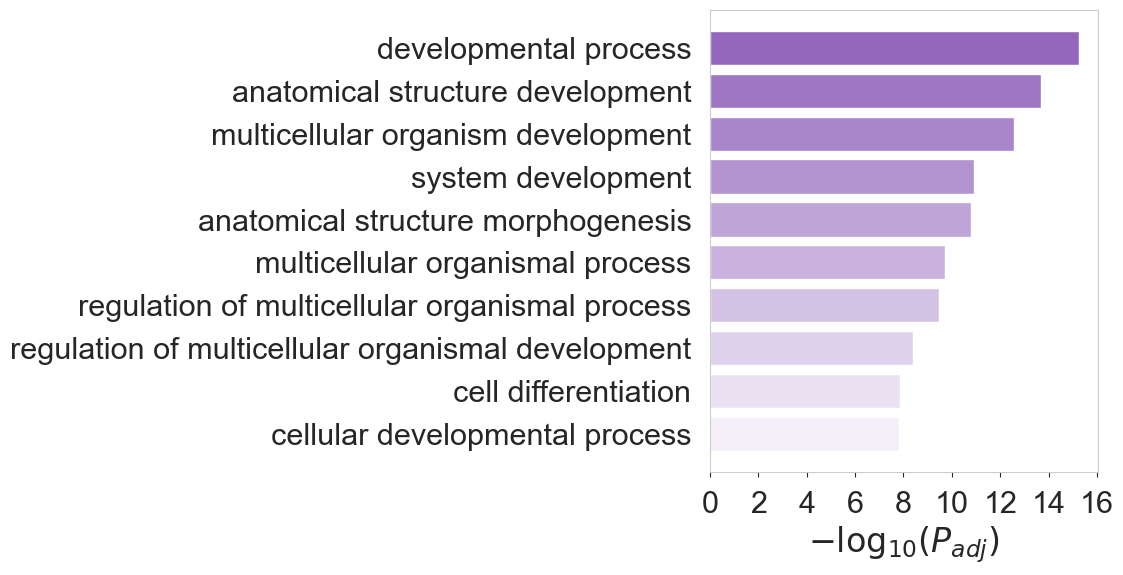

In [39]:
res_Impute_20.index = range(len(res_Impute_20))
go_colors = ["#F2E5F4FF", "#E0BEE6FF", "#CD92D8FF", "#B967C7FF", "#AB46BBFF",
             "#9B26B0FF", "#8D24AAFF", "#7A1FA1FF", "#6A1A99FF", "#4A138CFF"][::-1]

import matplotlib.colors

alphas = np.linspace(0.1, 1, 10)
rgba_colors = np.zeros((10, 4))
# for red the first column needs to be one
rgba_colors[:, :3] = matplotlib.colors.hex2color("tab:purple")
# the fourth column needs to be your alphas
rgba_colors[:, 3] = alphas
go_colors = rgba_colors[::-1]

plt.figure(figsize=(5, 6))

for i in range(10):
    plt.barh(10 - i, -np.log10(res_Impute_20.loc[i]['p_value']), color=go_colors[i])

plt.xticks(fontsize=22)
plt.yticks(10 - np.arange(10), [go for go in res_Impute_20['name'][:10].values], fontsize=22)
ax = plt.gca()
ax.tick_params(axis='both', which='major', pad=10)
ax.xaxis.set_ticks_position('bottom')
ax.grid(False)
plt.xlabel("$-\log_{10}(P_{adj})$", fontsize=24)
plt.savefig('./go_bp_2vs0.pdf')

In [57]:
mg = mg_2vs_0[:5] + mg_0vs2[:5]

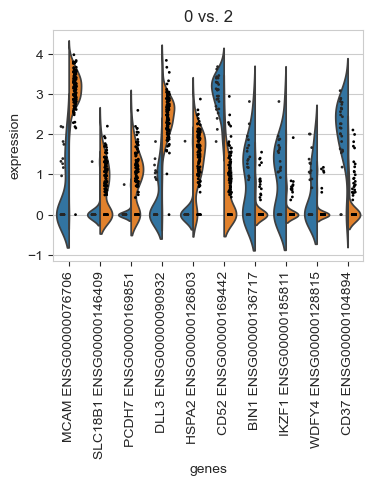

In [59]:

# 创建图形和坐标轴
fig, ax = plt.subplots(figsize=(4, 3))
# 设置坐标轴的位置
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# 在坐标轴上绘制图形
sc.pl.rank_genes_groups_violin(adata, gene_names=mg, jitter=True, key='0vs2_Impute', size=2, ax=ax, save=True)

In [33]:
pvals_adj = [i[0] for i in adata.uns['0vs2_Impute']["pvals_adj"]]
pvals = [i[0] for i in adata.uns['0vs2_Impute']["pvals"]]
logfoldchanges = [i[0] for i in adata.uns['0vs2_Impute']["logfoldchanges"]]

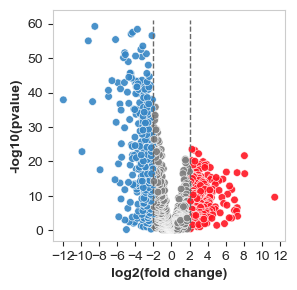

In [34]:
import seaborn as sns # Statistical visualization

result = pd.DataFrame()
result['x'] = logfoldchanges
result['y'] = -np.log10(pvals)
# result['pvals'] = pvals
# result['-log10(pvalue)']=-np.log10(logfoldchanges)

# 设置pvalue和logFC的阈值
# cut_off_pvalue = 0.0000001
cut_off_logFC = log2fc_min
#分组为up, normal, down
result.loc[(result.x> cut_off_logFC ),'group'] = 'up'
result.loc[(result.x< -cut_off_logFC ),'group'] = 'down'
result.loc[(result.x>=-cut_off_logFC )&(result.x<=cut_off_logFC ),'group'] = 'normal'

#绘制散点图
ax = sns.scatterplot(x="x", y="y",
                      hue='group', 
                      hue_order = ('down','normal','up'),
                      palette=("#3686C5","grey","#FF1623"), #palette=("#377EB8","grey","#E41A1C"),
                      alpha=0.9,
                      s=30,
                      legend=None,
                      data=result)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# 
ax.vlines(-cut_off_logFC, 0, 61, color='dimgrey',linestyle='dashed', linewidth=1) #画竖直线
ax.vlines(cut_off_logFC,  0, 61, color='dimgrey',linestyle='dashed', linewidth=1) #画竖直线
# # ax.hlines(-np.log10(cut_off_pvalue), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1) #画竖水平线
ax.set_xticks(range(-12, 14, 2))# 设置x轴刻度
ax.set_yticks(range(0, 61, 10))# 设置y轴刻度
ax.set_ylabel('-log10(pvalue)',fontweight='bold') # 设置y轴标签
ax.set_xlabel('log2(fold change)',fontweight='bold') # 设置x轴标签
ax.grid(False)
plt.savefig('./figures/huashantu0vs2.pdf')

In [35]:

result.loc[(result['x']>cut_off_logFC ) | (result['x']<-cut_off_logFC)& (result['y']>-np.log10(0.05))]

,x,y,group
0,2.581466,23.194939,up
1,2.273773,23.498502,up
2,3.499838,19.938410,up
3,3.003236,22.220435,up
4,3.885750,19.133952,up
...,...,...,...
1991,-4.448072,56.991809,down
1993,-6.171162,55.388764,down
1996,-4.290078,57.472760,down
1997,-8.460992,59.213615,down
